# 00. Preparation

## 00.1 install necessary and optional Python packages


`conda install cytoolz seaborn scikit-learn statsmodels numba pytables`

`conda install -c conda-forge scanpy python-igraph leidenalg`

`conda install -c conda-forge louvain multicore-tsne`

`pip3 install pyscenic`

## 00.2 Download auxiliary files and expression matrix (PBMC 10k from 10x Genomics)
`wget https://raw.githubusercontent.com/aertslab/pySCENIC/master/resources/hs_hgnc_tfs.txt`

`wget https://resources.aertslab.org/cistarget/motif2tf/motifs-v9-nr.hgnc-m0.001-o0.0.tbl`

`wget https://resources.aertslab.org/cistarget/databases/homo_sapiens/hg38/refseq_r80/mc9nr/gene_based/hg38__refseq-r80__10kb_up_and_down_tss.mc9nr.feather`

`wget http://cf.10xgenomics.com/samples/cell-exp/3.0.0/pbmc_10k_v3/pbmc_10k_v3_filtered_feature_bc_matrix.tar.gz`

`tar xvf pbmc_10k_v3_filtered_feature_bc_matrix.tar.gz`


# 01. Preprocessing

In [5]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import scanpy as sc
import loompy as lp

from pyscenic.rss import regulon_specificity_scores

In [40]:
adata = sc.read_10x_mtx(path="./data/filtered_feature_bc_matrix/", var_names="gene_symbols")
adata.var_names_make_unique()

In [56]:
mito_genes_index = adata.var_names.str.startswith('MT-')
adata.obs['percent_mito'] = np.ravel(np.sum(adata[:, mito_genes_index].X, axis=1) / np.sum(adata.X, axis=1))
adata.obs['n_counts']     = np.ravel(adata.X.sum(axis=1))
adata.obs['n_genes']      = np.ravel( (adata.X > 0).sum(axis=1) )

In [59]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)
adata = adata[adata.obs['n_genes']<4000, :]
adata = adata[adata.obs['percent_mito']<0.15, :]

In [71]:
import loompy as lp
row_attrs = {"Gene" : np.array(adata.var_names) }
col_attrs = {"CellID" : np.array(adata.obs_names),
             "nGene"  : np.array(adata.obs['n_genes']),
             "nUMI"   : np.array(adata.obs['n_counts'])
             }
lp.create("PBMC10k_filter.loom", adata.X.transpose(), row_attrs, col_attrs)

# 02. pySCENIC

docker run -it -v $PWD:$PWD aertslab/pyscenic:0.9.18 pyscenic grn --num_workers 10 --output $PWD/adj.tsv --method grnboost2 $PWD/PBMC10k_filter.loom $PWD/hs_hgnc_tfs.txt

docker run -it -v $PWD:$PWD aertslab/pyscenic:0.9.18 pyscenic ctx $PWD/adj.tsv $PWD/hg38__refseq-r80__10kb_up_and_down_tss.mc9nr.feather --annotations_fname $PWD/motifs-v9-nr.hgnc-m0.001-o0.0.tbl --expression_mtx_fname $PWD/PBMC10k_filter.loom --mode "dask_multiprocessing" --num_workers 10 --mask_dropouts -o $PWD/reg.csv

docker run -dit -v $PWD:$PWD aertslab/pyscenic:0.9.18 pyscenic aucell $PWD/PBMC10k_filter.loom $PWD/reg.csv --output $PWD/PBMC10k_SCENIC.loom --num_workers 10


# 03. dimension reduction

In [7]:
import loompy as lp
import umap
from MulticoreTSNE import MulticoreTSNE as TSNE

In [42]:
lf = lp.connect("./PBMC10k_SCENIC.loom", mode="r+", validate=False)
auc_mtx = pd.DataFrame(lf.ca.RegulonsAUC, index=lf.ca.CellID)
lf.close()

In [50]:
runUmap = umap.UMAP(n_neighbors=10, min_dist=0.4, metric="correlation")
dr_umap = runUmap.fit_transform(auc_mtx)

In [52]:
runTSNE = TSNE(n_jobs=8)
dr_tsne = runTSNE.fit_transform(auc_mtx)

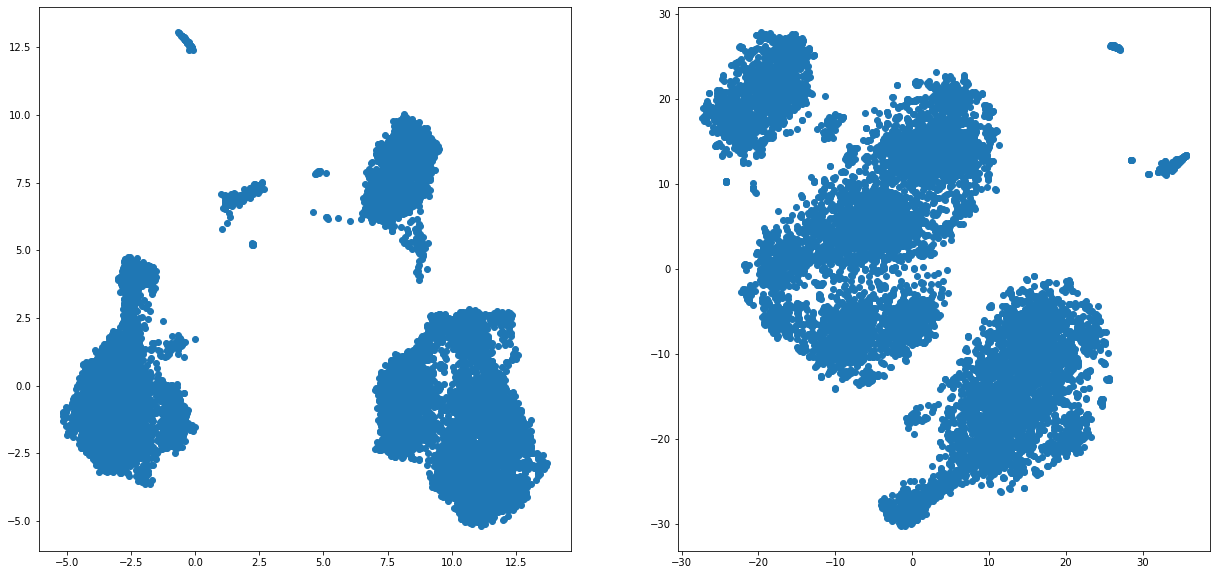

In [60]:
plt.figure(figsize=(21, 10))
plt.subplot(1, 2, 1)
plt.scatter(dr_umap[:, 0], dr_umap[:, 1])

plt.subplot(1, 2, 2)
plt.scatter(dr_tsne[:, 0], dr_tsne[:, 1])

plt.show()
plt.close()

# 04. RSS

In [101]:
from pyscenic.rss import regulon_specificity_scores
from pyscenic.plotting import plot_rss

In [62]:
auc_mtx.shape

(10280, 333)

In [93]:
n_type = 23
n_regulon = auc_mtx.shape[1]
cell_type_indicator = pd.Series(np.random.binomial(n=n_type, p=0.3, size=auc_mtx.shape[0]), index=auc_mtx.index)
rss_mtx = regulon_specificity_scores(auc_mtx, cell_type_indicator)

In [95]:
rss_mtx

,AHR(+),AIRE(+),ARNTL2(+),ASCL2(+),ATF1(+),ATF3(+),ATF4(+),ATF5(+),ATF6(+),ATF6B(+),...,ZNF607(+),ZNF674(+),ZNF682(+),ZNF71(+),ZNF76(+),ZNF81(+),ZNF821(+),ZNF831(+),ZNF91(+),ZSCAN31(+)
7,0.319697,0.192502,0.317183,0.324250,0.336039,0.334142,0.300671,0.325823,0.323806,0.326924,...,0.287797,0.228054,0.212250,0.221957,0.334696,0.311380,0.254340,0.314977,0.257028,0.228451
3,0.214863,0.180593,0.218054,0.216081,0.219648,0.218264,0.215274,0.217346,0.216365,0.218100,...,0.207976,0.190653,0.182284,0.192815,0.218321,0.216589,0.201615,0.212801,0.204970,0.191190
12,0.188166,0.179206,0.189905,0.188744,0.189382,0.189585,0.188330,0.189992,0.188915,0.188824,...,0.186098,0.183039,0.176299,0.180587,0.188719,0.186935,0.182115,0.189959,0.181375,0.187137
8,0.303437,0.195323,0.305181,0.305885,0.318031,0.315447,0.288626,0.304055,0.306635,0.311703,...,0.267196,0.214298,0.211966,0.229972,0.317032,0.290349,0.258362,0.298569,0.249690,0.225295
5,0.285276,0.187816,0.286294,0.292170,0.300265,0.297287,0.271452,0.291416,0.292098,0.294227,...,0.260689,0.220407,0.208261,0.223609,0.297745,0.278125,0.242020,0.280910,0.242077,0.220663
11,0.204086,0.187607,0.206731,0.207361,0.210958,0.209106,0.205291,0.208198,0.209408,0.208309,...,0.200381,0.188873,0.183708,0.189355,0.209873,0.203986,0.194199,0.209214,0.195231,0.193979
4,0.251549,0.184212,0.250684,0.250820,0.257161,0.256339,0.240866,0.251458,0.252543,0.252752,...,0.231997,0.212696,0.202648,0.202345,0.255203,0.243518,0.218188,0.244610,0.218909,0.204976
10,0.239909,0.175496,0.236763,0.240974,0.244720,0.246171,0.231238,0.241315,0.242975,0.240805,...,0.224362,0.202371,0.198052,0.209540,0.244118,0.235711,0.215156,0.233441,0.208498,0.198506
6,0.310060,0.186338,0.308047,0.318886,0.326496,0.325484,0.296647,0.313704,0.313344,0.317285,...,0.277953,0.223560,0.200689,0.222110,0.321518,0.298980,0.253041,0.302189,0.244201,0.225785
9,0.270170,0.189490,0.269178,0.271648,0.280304,0.279760,0.261035,0.273839,0.276591,0.277185,...,0.240546,0.207467,0.200641,0.218349,0.278483,0.261388,0.231976,0.263658,0.228494,0.216217


In [96]:
cell_type1_rss = rss_mtx.loc[1, :].sort_values(ascending=False)

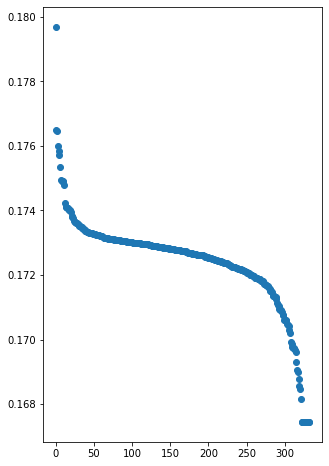

In [100]:
x = np.arange(n_regulon)

plt.figure(figsize=(5, 8))
plt.scatter(x, cell_type1_rss.values)
plt.show()
plt.close()

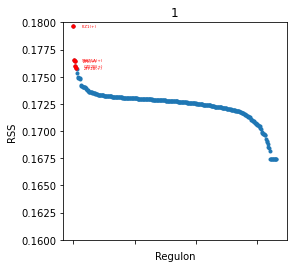

In [109]:
plot_rss(rss_mtx, 1, top_n=5)

In [ ]:
cell_type_indicator.unique().sort